### Non-Personalized Recommender

Non personalized recommender system is created when we do not want user specific recommendations, but kind of similar recommendation for everyone. This method therefore does not use any user preference but only item level metrics to make recommendations. Most popular items are recommended to all.

To find most popular items we can create a score based on simple means. If we need to create a recommendation given a selected item, we can use association rules to make the top recommendations.

The recommender system needs to be build using the following rules - 
1. Mean based recommender - Regular and Damped mean
2. Association rule based recommender - Basic and Lift based

We will use the following provided datasets - 

1. ratings.csv contains user ratings of movies
2. movies.csv contains details of the movies

to build a non-personalized recommender system of movies.

In [6]:
# import key libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import gc
import seaborn as sns

%matplotlib inline

sns.set(style='darkgrid')

In [2]:
# import datasets

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [5]:
print movies.shape, ratings.shape
print 'Unique movies : ', movies['movieId'].nunique()
print 'Unique users in ratings data : ', ratings['userId'].nunique()
print 'Unique movies in ratings data : ', ratings['movieId'].nunique()
print 'Unique genres in movies data : ', movies['genres'].nunique()

(2500, 3) (264505, 4)
Unique movies :  2500
Unique users in ratings data :  862
Unique movies in ratings data :  2500


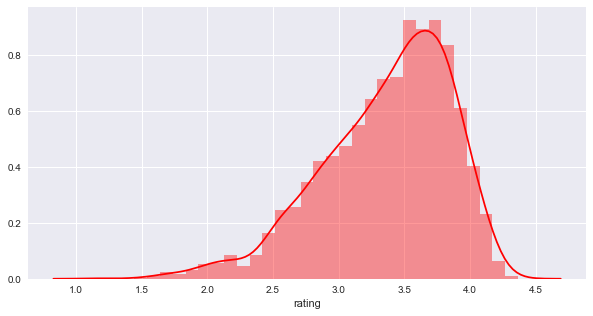

In [14]:
# Average ratings across all movies
mv_rating = ratings.groupby(by='movieId',as_index=False).agg({'rating':'mean'}).reset_index(drop=True)
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(mv_rating['rating'], color='red')

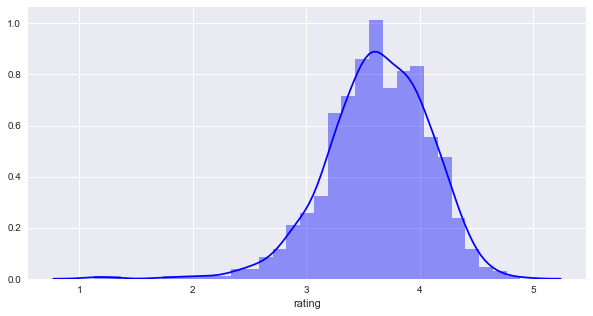

In [16]:
# Average ratings across all users
user_rating = ratings.groupby(by='userId',as_index=False).agg({'rating':'mean'}).reset_index(drop=True)
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(user_rating['rating'], color='blue')

### 1. Functions to compute mean and damped mean given the datasets

The mean formula for a movie i which has N users giving it rating is:

\begin{equation*}
M(i) = \frac{\sum_{u=1}^N R_u}{N}
\end{equation*}


The damped mean formula for a movie i which has N users giving it rating is:

\begin{equation*}
M(i) = \frac{\sum_{u=1}^N R_u + \alpha \mu}{N + \alpha}
\end{equation*}

where μ is the global mean rating for all movies and α is the damping factor.

In [17]:
# function which return top n movies as recommendations based on mean
def top_movie_mean(n):
    movies_temp = ratings.groupby(by='movieId', as_index=False).agg({'rating': 'mean'})
    movies_temp = movies_temp.sort_values(by='rating', ascending=False).reset_index(drop=True)
    movies_temp = movies_temp.merge(movies, on='movieId')
    return movies_temp.iloc[0:n][['title', 'rating']]

# function to return top n movies based on damped mean
def top_movie_damp_mean(n,alpha):
    gl_mean = ratings['rating'].mean()
    movies_temp = ratings.groupby(by='movieId', as_index=False).agg({'rating':['sum', 'count']})
    movies_temp.columns = ["_".join(x) for x in movies_temp.columns.ravel()]
    movies_temp.rename(columns={'movieId_':'movieId'}, inplace=True)
    movies_temp['damp_mean'] = (movies_temp['rating_sum'] + (alpha * gl_mean))/(movies_temp['rating_count'] + alpha)
    movies_temp = movies_temp.sort_values(by='damp_mean', ascending=False).reset_index(drop=True)
    movies_temp = movies_temp.merge(movies, on='movieId')
    return movies_temp.iloc[0:n][['title', 'damp_mean']]

In [18]:
top_movie_mean(8)

,title,rating
0,"Shawshank Redemption, The (1994)",4.364362
1,"Godfather, The (1972)",4.315848
2,Touch of Evil (1958),4.259259
3,Fight Club (1999),4.258503
4,Band of Brothers (2001),4.247423
5,12 Angry Men (1957),4.246032
6,Stop Making Sense (1984),4.220000
7,"Godfather: Part II, The (1974)",4.218462


In [19]:
top_movie_damp_mean(8,5)

,title,damp_mean
0,"Shawshank Redemption, The (1994)",4.356802
1,"Godfather, The (1972)",4.306888
2,Fight Club (1999),4.252142
3,12 Angry Men (1957),4.226909
4,Pulp Fiction (1994),4.212007
5,Band of Brothers (2001),4.210983
6,"Godfather: Part II, The (1974)",4.207637
7,Touch of Evil (1958),4.195260


### 2. Compute best recommendation based on association rule

1. Basic Association score for a movie i given for a movie j is:

\begin{equation*}
S(i|j) = \frac{P(i \cap j)}{P(j)}
\end{equation*}

where $P(i \cap j)$ is count of users who watched both i and j, and $P(j)$ is the count of users who watched j.

2. Lift based association score for a movie i given for a movie j is:

\begin{equation*}
S(i|j) = \frac{P(i \cap j)}{P(j)P(i)}
\end{equation*}

where $P(i \cap j)$ is count of users who watched both i and j, $P(j)$ is the count of users who watched j
and $P(i)$ is the count of users who watched movie i.

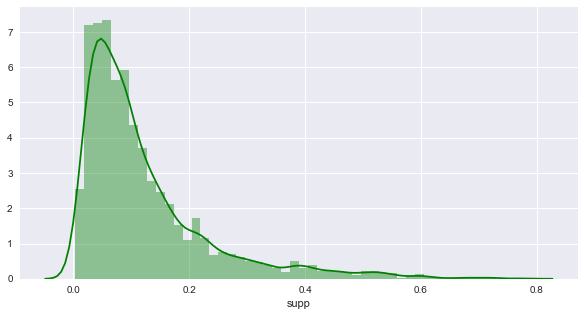

In [26]:
# Before calculating association scores of each movie with every other movie we want to 
# keep only relevant ones. We will remove movies which have very small number of users
# watching it. This is called keeping min support threshold.

rel_movies = ratings.groupby(by='movieId', as_index=False).agg({'userId':'count'})
rel_movies['supp'] = (1.0*rel_movies['userId'])/ratings['userId'].nunique()
rel_movies = rel_movies.sort_values(by='supp', ascending=False).reset_index(drop=True)
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(rel_movies['supp'], color='green')

In [38]:
# let's keep min support criteria as 0.4 - 
# which means we only keep movies which 40% of all population has seen
print 'Relevant number of movies only : ', rel_movies[rel_movies['supp'] >= 0.4].shape[0]

rel_movies = rel_movies[rel_movies['supp'] >= 0.4]

Relevant number of movies only :  103


In [40]:
rel_movies.tail()

,movieId,userId,supp
98,1200,349,0.404872
99,586,349,0.404872
100,4022,348,0.403712
101,592,348,0.403712
102,2918,346,0.401392


In [42]:
# calculate the association score for all movies (2500) 
# wrt. every relevant movie (103) and keeps the score in a dataframe 

st = time.time()

base_ass_score = pd.DataFrame(columns=['base_mvid', 'ass_mvid', 'base_cust',\
                                       'ass_cust', 'base_ass_cust', 'base_score', 'lift_score'])

for base_mvid in ratings['movieId'].unique():
    
    # number of cust who watched base movie
    mv1 = ratings[ratings['movieId'] == base_mvid]
    base_cust = mv1['userId'].nunique()  
    
    for ass_mvid in rel_movies['movieId'].unique():
        
        mv2 = ratings[ratings['movieId'] == ass_mvid]
        # number of customers who watched ass movie
        ass_cust = mv2['userId'].nunique()
        # number of customers who watched base and ass movie both
        base_ass_cust = mv1.merge(mv2, on='userId', how='inner')['userId'].nunique()

        temp = pd.DataFrame(columns=['base_mvid', 'ass_mvid', 'base_cust',\
                                       'ass_cust', 'base_ass_cust', 'base_score', 'lift_score'])
        if base_ass_cust > 0:
            base_score = (1.0 * base_ass_cust)/base_cust
            lift_score = (1.0 * base_ass_cust)/(base_cust * ass_cust)
        else:
            base_score = 0
            lift_score = 0
        
        temp.loc[0] = [base_mvid, ass_mvid, base_cust, ass_cust, base_ass_cust, base_score, lift_score]
        base_ass_score = base_ass_score.append(temp)
        
        del temp
        del mv2
    
    del mv1
    gc.collect()

et = time.time()    
print 'Number of rows of score dataset : ', base_ass_score.shape[0]
print 'Time taken :', round((et - st)/60,2), 'mins'

# Time taken for 10 movies vs 10 movies: 1.00676776568 mins
# Time taken for 2500 movies vs 103 movies: 37.5 mins

Number of rows of score dataset :  257500
Time taken : 37.25 mins


In [44]:
base_ass_score.head()

,base_mvid,ass_mvid,base_cust,ass_cust,base_ass_cust,base_score,lift_score
0,1.0,2571.0,496.0,668.0,443.0,0.893145,0.001337
0,1.0,4993.0,496.0,628.0,422.0,0.850806,0.001355
0,1.0,356.0,496.0,621.0,434.0,0.875000,0.001409
0,1.0,296.0,496.0,613.0,403.0,0.812500,0.001325
0,1.0,5952.0,496.0,597.0,400.0,0.806452,0.001351


In [ ]:
# add associated movies names and details in score dataset
basetemp.rename(columns={'ass_mvid' : 'movieId'})
base_ass_score = base_ass_score.merge(movies, on='')

### 2.1 Function to give top recommendation based on association scores

input taken - movie id
output - top n associated movie id and names

In [49]:
def top_base_ass_movie(base_mvid, n):
    temp = base_ass_score[base_ass_score['base_mvid'] == base_mvid]
    temp = temp.sort_values(by='base_score', ascending=False).reset_index(drop=True)[0:n]
    temp = temp.rename(columns={'ass_mvid' : 'movieId'})
    temp = temp.merge(movies,on='movieId', how='inner')
    return temp[['base_mvid', 'movieId', 'title', 'base_score']]
    
top_base_ass_movie(4, 5)

,base_mvid,movieId,title,base_score
0,4.0,4306,Shrek (2001),1.000000
1,4.0,2716,Ghostbusters (a.k.a. Ghost Busters) (1984),0.923077
2,4.0,1721,Titanic (1997),0.923077
3,4.0,356,Forrest Gump (1994),0.923077
4,4.0,4226,Memento (2000),0.923077


In [50]:
def top_lift_ass_movie(base_mvid, n):
    temp = base_ass_score[base_ass_score['base_mvid'] == base_mvid]
    temp = temp.sort_values(by='lift_score', ascending=False).reset_index(drop=True)[0:n]
    temp = temp.rename(columns={'ass_mvid' : 'movieId'})
    temp = temp.merge(movies,on='movieId', how='inner')
    return temp[['base_mvid', 'movieId', 'title', 'lift_score']]
    
top_lift_ass_movie(4, 5)

,base_mvid,movieId,title,lift_score
0,4.0,1197,"Princess Bride, The (1987)",0.002600
1,4.0,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,0.002442
2,4.0,6711,Lost in Translation (2003),0.002367
3,4.0,588,Aladdin (1992),0.002364
4,4.0,1704,Good Will Hunting (1997),0.002337


In [57]:
print 'Movie id number 4306 : ', movies[movies['movieId'] == 4306]['title'].iloc[0]

Movie id number 4306 :  Shrek (2001)


In [58]:
top_base_ass_movie(4306,3)

,base_mvid,movieId,title,base_score
0,4306.0,4306,Shrek (2001),1.000000
1,4306.0,2571,"Matrix, The (1999)",0.903288
2,4306.0,4993,"Lord of the Rings: The Fellowship of the Ring,...",0.891683


In [59]:
top_lift_ass_movie(4306,3)

,base_mvid,movieId,title,lift_score
0,4306.0,4306,Shrek (2001),0.001934
1,4306.0,4886,"Monsters, Inc. (2001)",0.001686
2,4306.0,2683,Austin Powers: The Spy Who Shagged Me (1999),0.001680
